# Process output of PED-Sim into ancIBD dataframes
Use ancIBD summary statistic and IBD table format

In [3]:
import numpy as np
import os as os
import sys as sys
import multiprocessing as mp
import pandas as pd
import socket
import matplotlib.pyplot as plt
import h5py as h5py
from scipy import interpolate

### Pick the right path (whether on cluster or at home)
socket_name = socket.gethostname()
print(socket_name)
if socket_name == "VioletQueen":
    path = "/home/harald/git/HAPSBURG/"   # The Path on Harald's machine
elif socket_name.startswith("bionc21") or socket_name.startswith("hpc"):
    print("Leipzig head node detected.")
    path = "/mnt/archgen/users/hringbauer/git/ped-sim/"  # The Path on Midway Cluster
elif socket_name.startswith("midway2"):
    print("Midway jnovmbre partition detected.")
    path = "/project2/jnovembre/hringbauer/ped-sim/"  # The Path on Midway Cluster
elif socket_name.startswith("Harald-Laptop"):
    print("Harald's new laptop detected!")
    path = "/home/hringbauer/git/ped-sim/" 
elif socket_name.startswith("compute-"):
    print("HSM Computational partition detected.")
    path = "/n/groups/reich/hringbauer/git/ped-sim/"  # The Path on Midway Cluster
else: 
    raise RuntimeWarning("Not compatible machine. Check!!")
    
os.chdir(path)  # Set the right Path (in line with Atom default)

sys.path.append("./package/")  # Go to the hapsburg package directory

from hapsburg.PackagesSupport.pp_individual_roh_csvs import post_process_roh_df, combine_ROH_df, calc_average_roh
from hapsburg.figures.plot_bars import plot_panel_row, prepare_dfs_plot, create_cousins_roh

#sys.path.insert(0,"/n/groups/reich/hringbauer/git/hapBLOCK/package/")  # hack to get development package first in path
from ancIBD.IO.ind_ibd import create_ind_ibd_df

print(os.getcwd()) # Show the current working directory. Should be HAPSBURG/Notebooks/ParallelRuns
print(f"CPU Count: {mp.cpu_count()}")

hpc030
Leipzig head node detected.
/mnt/archgen/users/hringbauer/git/ped-sim
CPU Count: 128


In [24]:
def load_segment_file(path_segments="../ped-sim/output/output.seg",
                      cm_fac=0.01):
    """Load and return segment File of IBD & ROH blocks.
    Return Pandas dataframe. 
    cm_fac: Factor with which to multiply genetic length columns"""
    df = pd.read_csv(path_segments, sep="\t", header=None)
    df.columns = ["iid1", "iid2", "ch", "Start", "End", 
                  "ibd_stat", "StartM", "EndM", "lengthM"]
    df["length"] = (df["End"] - df["Start"])
    
    for col in ["StartM", "EndM", "lengthM"]:
        df[col] = df[col] * cm_fac  # Correct that original is in cm
    return df

def filter_spouse_ibd_df(df, col="iid1", output=True):
    """Filter PED-SIM Spouses in column col.
    Return Filtered df"""
    s = df[col].str.split("-").str[-1].str[0]
    idx = s=="s"
    df = df[~idx].reset_index(drop=True).copy()
    if output:
        print(f"Filtered to {len(df)} / {len(idx)}) Entries without Spouse")
    return df

def to_hapsburg_ibd_df(path_segments = "../ped-sim/output/test.seg",
                   savepath = "", n=500, merge=False,
                   h5_path = "", col_no_spouse = "",
                   min_cms=[8, 12, 16, 20], snp_cm=220,
                   max_gap=0, output=False, sort=True):
    """Load pd_sim output and post_process into Hapsburg
    Summary output. Return this dataframe.
    If savepath is given, save to there (tab-seperated)
    max_gap: Maximumg Gap to merge [Morgan]."""
    df1 = load_segment_file(path_segments)  # Load the full segment file, transfomred
    
    if max_gap>0:
        df1 = merge_gaps(df1, max_gap=max_gap, coutput=True)
        print(f"Merging Gaps... Done")
    elif merge:
        df1 = merge_called_blocks2(df1, output=True)
        print(f"Merging... Done")
    else:
        print(f"No merging done!")
        
    ### Pre-Process if h5 given to fit ancIBD table specs
    if len(h5_path)>0:
        df1 = cap_ibd_boarders(df1, h5_path=h5_path)
        df1 = transform_to_snp_pos(df1, h5_path=h5_path)
        
    ### Prepare Indivdiual IBD
    df_ibd = create_ind_ibd_df(ibd_data=df1,
                  min_cms=min_cms, snp_cm=snp_cm, min_cm=4,
                  sort_col=-1, savepath="",
                  output=False)
    
    ### Filter Spouses in PedSim output
    if len(col_no_spouse)>0:
        df_ibd = filter_spouse_ibd_df(df_ibd, col=col_no_spouse, output=output)
        
    ### Save if needed
    if len(savepath) > 0:
        df_ibd.to_csv(savepath, sep="\t", index=False)
        if output:
            print(f"Saved {len(df_ibd)} individual IBD pairs to: {savepath}")
        
    #assert(len(df_ibd)==n) # can be <n if IBD=0 pairs!   
    return df_ibd

def merge_called_blocks(df, output=False):
        """Merge adjacent Blocks in Dataframe df and return merged Dataframe."""
        if len(df) == 0:
            return df  # In case of empty dataframe don't do anything

        df_n = df.drop(df.index)  # Create New Data frame with all raws removed
        row_c = df.iloc[0, :].copy()
        #row_c["lengthM"] = row_c["EndM"] - row_c["StartM"] # Should be there

        # Iterate over all further rows, update blocks if gaps small enough
        for index, row in df.iloc[1:,:].iterrows():
            ### Calculate Conditions
            con1 = (row["Start"] == row_c["End"]+1)
            con2 = row["ch"] == row_c["ch"]
            con3 = row["iid1"] == row_c["iid1"]
            con4 = row["iid2"] == row_c["iid2"]
            
            if con1 & con2 & con3 & con4:
                row_c["End"] = row["End"]
                row_c["EndM"] = row["EndM"]
                row_c["length"] = row_c["End"] - row_c["Start"]
                row_c["lengthM"] = row_c["EndM"] - row_c["StartM"]

            else:  # Save and go to next row
                df_n.loc[len(df_n)] = row_c  # Append a row to new df
                row_c = row.copy()

        df_n.loc[len(df_n)] = row_c   # Append the last row

        if output == True:
            print(f"Merged n={len(df) - len(df_n)} gaps")
        return df_n

def merge_called_blocks2(df, output=False):
        """Merge Blocks in Dataframe df and return merged Dataframe.
        Gap is given in Morgan. Faster version, vectorized instead of for loop"""
        if len(df) == 0:
            return df  # In case of empty dataframe don't do anything

        idx1 = df["Start"].values[1:] == df["End"].values[:-1]+1
        idx2 = df["ch"].values[1:] == df["ch"].values[:-1]
        idx3 = df["iid1"].values[1:] == df["iid1"].values[:-1]
        idx4 = df["iid2"].values[1:] == df["iid2"].values[:-1]
        
        idx = idx1 & idx2 & idx3 & idx4

        print(f"{np.sum(idx)} Gaps to merge!")
        
        ### Concatenate Segments
        idx1 = np.concatenate(([False], idx, [False])).astype("int8")
        diff = np.diff(idx1) # [a[i]-a[i-1]

        i1 =  np.where(diff==1)[0] # Where block to concatenate starts
        i2 = np.where(diff==-1)[0] # Last segment to conatenate
        assert(len(i1)==len(i2))
        
        df.loc[i1, "End"] = df.loc[i2, "End"].values
        df.loc[i1, "EndM"] = df.loc[i2, "EndM"].values
        ### Update Lengths
        df.loc[i1, "length"] = df.loc[i1,"End"].values - df.loc[i1, "Start"].values
        df.loc[i1, "lengthM"] = df.loc[i1,"EndM"].values - df.loc[i1, "StartM"].values
        
        idx2 =idx1[:-1].astype("bool")
        #print(idx2[-10:])
        #print(df.head())
        df = df[~idx2]#.reset_index(drop=True).copy() # Copy all starting segments (extended now)
        return df
    
def merge_gaps(df, max_gap=0.01, coutput=False):
        """Merge Gaps in Dataframe df and return merged Dataframe.
        Gap is given in Morgan. Faster version, vectorized instead of for loop"""
        if len(df) == 0:
            return df  # In case of empty dataframe don't do anything

        idx1 = (df["StartM"].values[1:] - df["EndM"].values[:-1]) < max_gap
        idx2 = df["ch"].values[1:] == df["ch"].values[:-1]
        idx3 = df["iid1"].values[1:] == df["iid1"].values[:-1]
        idx4 = df["iid2"].values[1:] == df["iid2"].values[:-1]
        
        idx = idx1 & idx2 & idx3 & idx4

        print(f"{np.sum(idx)} Gaps to merge!")
        
        ### Concatenate Segments
        idx1 = np.concatenate(([False], idx, [False])).astype("int8")
        diff = np.diff(idx1) # [a[i]-a[i-1]

        i1 =  np.where(diff==1)[0] # Where block to concatenate starts
        i2 = np.where(diff==-1)[0] # Last segment to conatenate
        assert(len(i1)==len(i2))
        
        df.loc[i1, "End"] = df.loc[i2, "End"].values
        df.loc[i1, "EndM"] = df.loc[i2, "EndM"].values
        ### Update Lengths
        df.loc[i1, "length"] = df.loc[i1,"End"].values - df.loc[i1, "Start"].values
        df.loc[i1, "lengthM"] = df.loc[i1,"EndM"].values - df.loc[i1, "StartM"].values
        
        idx2 =idx1[:-1].astype("bool")
        #print(idx2[-10:])
        #print(df.head())
        df = df[~idx2]#.reset_index(drop=True).copy() # Copy all starting segments (extended now)
        return df
    
##############################
### Adapt to SNPs in h5

def cap_ibd_boarders(df, chs = range(1,23), 
                     h5_path = "/n/groups/reich/hringbauer/git/hapBLOCK/data/hdf5/1240k_v54.1/ch"):
    """Cuts IBD segment file for ch in chs to boundaries matching h5 in h5_path"""
    
    for ch in chs:
        with h5py.File(f"{h5_path}{ch}.h5", "r") as f: # Load for Sanity Check. See below!
            min_map, max_map =  f["variants/MAP"][0],f["variants/MAP"][-1]

        idx_ch = df["ch"]==ch ## Find all segments on chromosome

        ### Cut to Start Positions
        idx = df["StartM"]<min_map
        df.loc[idx_ch & idx, "StartM"] = min_map
        idx = df["EndM"]<min_map
        df.loc[idx_ch & idx, "EndM"] = min_map

        ### Cut to End Positions
        idx = df["StartM"]>max_map
        df.loc[idx_ch & idx, "StartM"] = max_map
        idx = df["EndM"]>max_map
        df.loc[idx_ch & idx, "EndM"] = max_map

    df["LengthM"]= df["EndM"]-df["StartM"] # Update IBD Length
    ### Remove IBD segments fully out of boarder
    idx = df["LengthM"]==0
    df = df[~idx].copy().reset_index(drop=True) 
    return df

def transform_to_snp_pos(df, chs=range(1,23), 
                         h5_path = "/n/groups/reich/hringbauer/git/hapBLOCK/data/hdf5/1240k_v54.1/ch"):
    """Transform positions in IBD dataframe to positions matching indices in 1240k file"""
    
    for ch in chs:
        with h5py.File(f"{h5_path}{ch}.h5", "r") as f: # Load for Sanity Check. See below!
                m = f["variants/MAP"][:]
        m = m + np.arange(len(m))/1e8 # To make sure monotonically increasing
        p = np.arange(len(m))
        f = interpolate.interp1d(m, p)
        
        ### Map to approximate index positions
        idx_ch = df["ch"]==ch ## Find all segments on chromosome
        df.loc[idx_ch, "Start"] = f(df["StartM"][idx_ch]).astype("int") 
        df.loc[idx_ch, "End"] = f(df["EndM"][idx_ch]).astype("int") 
    df["length"] = df["End"] - df["Start"]
    return df

In [22]:
a = np.array([0.2,1.2,0.7])
a.astype("int")

array([0, 1, 0])

# Convert to hapBLOCK format

In [6]:
out_folder = "/n/groups/reich/hringbauer/git/hapBLOCK/output/pedsim/"

In [6]:
df1 = load_segment_file(path_segments = "./output/ibd/sib.seg")

In [ ]:
df1[df1["iid1"].str.contains("sib1_g2-b1-i1")][:50]

In [18]:
dft = df1[df1["iid1"].str.contains("gp11_g1")]
np.sum(dft["lengthM"])

33.46297627

In [85]:
%%time
df_av2 = to_hapsburg_ibd_df(path_segments = "./output/ibd/av2.seg", 
                     n=100, savepath=out_folder+"av2.tsv")

Saved 100 individual IBD pairs to: /n/groups/reich/hringbauer/git/hapBLOCK/output/pedsim/av2.tsv
CPU times: user 379 ms, sys: 2.92 ms, total: 382 ms
Wall time: 389 ms


In [92]:
%%time
df_av1 = to_hapsburg_ibd_df(path_segments = "./output/ibd/av1.seg", 
                     n=100, savepath=out_folder+"av1.tsv")

Saved 100 individual IBD pairs to: /n/groups/reich/hringbauer/git/hapBLOCK/output/pedsim/av1.tsv
CPU times: user 382 ms, sys: 1.97 ms, total: 384 ms
Wall time: 389 ms


In [94]:
%%time
df_av3 = to_hapsburg_ibd_df(path_segments = "./output/ibd/av2.seg", 
                     n=100, savepath=out_folder+"av2.tsv")

Saved 100 individual IBD pairs to: /n/groups/reich/hringbauer/git/hapBLOCK/output/pedsim/av2.tsv
CPU times: user 381 ms, sys: 8.05 ms, total: 389 ms
Wall time: 389 ms


In [104]:
%%time
df_av5 = to_hapsburg_ibd_df(path_segments = "./output/ibd/av3.seg", 
                     n=100, savepath=out_folder+"av3.tsv")

Saved 100 individual IBD pairs to: /n/groups/reich/hringbauer/git/hapBLOCK/output/pedsim/av3.tsv
CPU times: user 402 ms, sys: 1.92 ms, total: 404 ms
Wall time: 407 ms


In [103]:
%%time
df_av5 = to_hapsburg_ibd_df(path_segments = "./output/ibd/av4.seg", 
                     n=100, savepath=out_folder+"av4.tsv")

Saved 100 individual IBD pairs to: /n/groups/reich/hringbauer/git/hapBLOCK/output/pedsim/av4.tsv
CPU times: user 397 ms, sys: 1.98 ms, total: 399 ms
Wall time: 403 ms


In [102]:
%%time
df_av5 = to_hapsburg_ibd_df(path_segments = "./output/ibd/av5.seg", 
                     n=100, savepath=out_folder+"av5.tsv")

Saved 100 individual IBD pairs to: /n/groups/reich/hringbauer/git/hapBLOCK/output/pedsim/av5.tsv
CPU times: user 382 ms, sys: 5.96 ms, total: 388 ms
Wall time: 397 ms


### Grand Parental Relationships

In [107]:
%%time
df_gp0 = to_hapsburg_ibd_df(path_segments = "./output/ibd/parent.seg", 
                            n=100, savepath=out_folder+"parent.tsv")

Saved 400 individual IBD pairs to: /n/groups/reich/hringbauer/git/hapBLOCK/output/pedsim/parent.tsv
CPU times: user 1.3 s, sys: 9.96 ms, total: 1.31 s
Wall time: 1.32 s


In [8]:
%%time
df_gp1 = to_hapsburg_ibd_df(path_segments = "./output/ibd/gp1.seg", 
                            n=100, savepath=out_folder+"gp1.tsv")
df_gp1 = df_gp1[::2]

Saved 200 individual IBD pairs to: /n/groups/reich/hringbauer/git/hapBLOCK/output/pedsim/gp1.tsv
CPU times: user 784 ms, sys: 9.12 ms, total: 793 ms
Wall time: 822 ms


In [ ]:
%%time
df_gp2 = to_hapsburg_ibd_df(path_segments = "./output/ibd/gp2.seg", n=100,
                     savepath=out_folder+"gp2.tsv") #out_folder+"gp2.tsv"
#df_gp2 = df_gp2[::2]

In [77]:
%%time
df_gp3 = to_hapsburg_ibd_df(path_segments = "./output/ibd/gp3.seg", 
                     clst="gp3", n=100,
                     savepath=out_folder+"gp3.tsv")
df_gp3 = df_gp3[::2]

Saved 200 individual IBD pairs to: /n/groups/reich/hringbauer/git/hapBLOCK/output/pedsim/gp3.tsv
CPU times: user 694 ms, sys: 3.99 ms, total: 698 ms
Wall time: 706 ms


In [132]:
%%time
df_sib = to_hapsburg_ibd_df(path_segments = "./output/ibd/sib.seg", 
                     n=100, savepath=out_folder+"sib.tsv", merge=True) ### Merging is activated here

Merged n=6646 gaps
Saved 100 individual IBD pairs to: /n/groups/reich/hringbauer/git/hapBLOCK/output/pedsim/sib.tsv
CPU times: user 28.7 s, sys: 32.1 ms, total: 28.7 s
Wall time: 28.7 s


In [81]:
%%time
df_hsib = to_hapsburg_ibd_df(path_segments = "./output/ibd/hsib.seg", 
                     clst="hsib", n=100,
                     savepath=out_folder+"hsib.tsv")

Saved 100 individual IBD pairs to: /n/groups/reich/hringbauer/git/hapBLOCK/output/pedsim/hsib.tsv
CPU times: user 378 ms, sys: 5.04 ms, total: 384 ms
Wall time: 394 ms


## 2) Pre-Process with H5 Filter to filtered output
Using the cap outside of mapable region plus SNP density filter

In [104]:
h5_path = "/n/groups/reich/hringbauer/git/hapBLOCK/data/hdf5/1240k_v54.1/ch"
out_folder = "/n/groups/reich/hringbauer/git/hapBLOCK/output/pedsim/"

In [105]:
%%time
for i in range(1,6):
    p = "av" + str(i)
    dft = to_hapsburg_ibd_df(path_segments = f"./output/ibd/{p}.seg", 
                             h5_path=h5_path, savepath=out_folder+f"{p}.f.tsv")

Saved 100 individual IBD pairs to: /n/groups/reich/hringbauer/git/hapBLOCK/output/pedsim/av1.f.tsv
Saved 100 individual IBD pairs to: /n/groups/reich/hringbauer/git/hapBLOCK/output/pedsim/av2.f.tsv
Saved 100 individual IBD pairs to: /n/groups/reich/hringbauer/git/hapBLOCK/output/pedsim/av3.f.tsv
Saved 100 individual IBD pairs to: /n/groups/reich/hringbauer/git/hapBLOCK/output/pedsim/av4.f.tsv
Saved 99 individual IBD pairs to: /n/groups/reich/hringbauer/git/hapBLOCK/output/pedsim/av5.f.tsv
CPU times: user 3.18 s, sys: 107 ms, total: 3.29 s
Wall time: 4.14 s


In [106]:
for i in range(1,4):
    p = "gp" + str(i)
    dft = to_hapsburg_ibd_df(path_segments = f"./output/ibd/{p}.seg", 
                     h5_path=h5_path,
                     savepath=out_folder+f"{p}.f.tsv")

Saved 200 individual IBD pairs to: /n/groups/reich/hringbauer/git/hapBLOCK/output/pedsim/gp1.f.tsv
Saved 200 individual IBD pairs to: /n/groups/reich/hringbauer/git/hapBLOCK/output/pedsim/gp2.f.tsv
Saved 200 individual IBD pairs to: /n/groups/reich/hringbauer/git/hapBLOCK/output/pedsim/gp3.f.tsv


In [107]:
%%time
df_gp0 = to_hapsburg_ibd_df(path_segments = "./output/ibd/parent.seg", 
                            n=100, h5_path=h5_path, savepath=out_folder+"parent.f.tsv")

Saved 400 individual IBD pairs to: /n/groups/reich/hringbauer/git/hapBLOCK/output/pedsim/parent.f.tsv
CPU times: user 1.3 s, sys: 15.9 ms, total: 1.31 s
Wall time: 1.48 s


In [ ]:
%%time
df_sib = to_hapsburg_ibd_df(path_segments = "./output/ibd/sib.seg", 
                     h5_path=h5_path, savepath=out_folder+"sib.f.tsv", merge=True) ### Merging is activated here

Merged n=6646 gaps


In [ ]:
%%time
df_hsib = to_hapsburg_ibd_df(path_segments = "./output/gp2.seg", 
                             h5_path=h5_path, savepath=out_folder+"hsib.f.tsv")

# 3) Process 10k/50k Simulations for Ben
Simulations of 10k/50k per replicate, done in October 2024/ Feb 2025

## 3a) Single Test Case

In [5]:
outfolder = "/mnt/archgen/users/hringbauer/output/pedsim/ben50k/"
h5_path = "/mnt/archgen/ibd_release/data/h5.master/v7.1/ch"

In [37]:
%%time
dft = to_hapsburg_ibd_df(path_segments = "./output/ben10k/gp3.seg", n=10000,
                         h5_path=h5_path, col_no_spouse="iid1",
                         savepath=os.path.join(outfolder,"gp3.tsv"))

CPU times: user 41.4 s, sys: 478 ms, total: 41.9 s
Wall time: 55.1 s


In [30]:
#dfx = filter_spouse_ibd_df(dft)

Filtered to 8875 / 17771) Entries without Spouse


In [40]:
np.mean(dft["n_IBD>12"])

9.1195

In [41]:
np.mean(dft["sum_IBD>12"])

352.75759780680005

In [49]:
%%time
dft = to_hapsburg_ibd_df(path_segments = "./output/ben10k/av3.seg", n=10000,
                         h5_path=h5_path, col_no_spouse="",
                         savepath=os.path.join(outfolder,"av3.tsv"))

CPU times: user 20.4 s, sys: 162 ms, total: 20.5 s
Wall time: 20.5 s


In [50]:
np.mean(dft["n_IBD>12"])

19.1755

In [51]:
np.mean(dft["sum_IBD>12"])

683.7132404335999

In [54]:
len(dft)

10000

## 3b) Process all GPs

In [ ]:
rels = [f"gp{i}" for i in range(1,13)]

dfts = [] # Result IBD dataframe list
for r in rels:
    print(f"Running {r}...")
    dft = to_hapsburg_ibd_df(path_segments = f"./output/ben50k/{r}.seg", n=50000,
                         h5_path=h5_path, col_no_spouse="iid1", merge=True,
                         savepath=os.path.join(outfolder,f"{r}.tsv"))
    dfts.append(dft)

In [ ]:
print(f"Finished")

In [48]:
[np.mean(dft["sum_IBD>12"]) for dft in dfts]

[1523.2851487385,
 735.1855815658,
 352.75759780680005,
 168.0259323841842,
 80.15155665531698,
 43.09825078659155,
 25.385623307374715,
 17.7458015921381]

In [53]:
rels

['gp1', 'gp2', 'gp3', 'gp4', 'gp5', 'gp6', 'gp7', 'gp8']

## 3c) Process all avunculars

In [ ]:
rels = [f"av{i}" for i in range(2,13)]

dfts = [] # Result IBD dataframe list
for r in rels:
    dft = to_hapsburg_ibd_df(path_segments = f"./output/ben50k/{r}.seg", n=50000,
                         h5_path=h5_path, col_no_spouse="", merge=True,
                         savepath=os.path.join(outfolder,f"{r}.tsv"))
    dfts.append(dft)

In [ ]:
print("Finished")

In [57]:
[np.mean(dft["sum_IBD>8"]) for dft in dfts]

[1462.4879566866,
 708.2551129084001,
 344.63930038600006,
 167.7862662967374,
 82.07977099443038,
 43.19106461694878,
 25.6381693844889,
 17.366125536796538]

In [58]:
[len(dft["sum_IBD>8"]) for dft in dfts]

[10000, 10000, 10000, 9992, 9875, 9098, 7298, 5082]

### 3d) Process specific cases

In [ ]:
dft = to_hapsburg_ibd_df(path_segments = f"./output/ben50k/po.seg", n=1,
                         h5_path=h5_path, col_no_spouse="iid1",
                         savepath=os.path.join(outfolder,f"po.tsv"))

In [ ]:
%%time
dft = to_hapsburg_ibd_df(path_segments = f"./output/ben50k/fs.seg", n=50000,
                         h5_path=h5_path, col_no_spouse="", merge=True,
                         savepath=os.path.join(outfolder, f"fs.tsv"))

In [ ]:
%%time
dft = to_hapsburg_ibd_df(path_segments = f"./output/ben50k/cf3.seg", n=50000,
                         h5_path=h5_path, col_no_spouse="", merge=True,
                         savepath=os.path.join(outfolder, f"cf3.tsv"))

In [132]:
np.mean(dft["sum_IBD>12"])#/3100

669.4882798314001

In [101]:
np.mean(dft["n_IBD>12"]) #62.2762

34.8754

In [98]:
print(outfolder)

/mnt/archgen/users/hringbauer/output/pedsim/ben10k/


In [3]:
print(f"Finished")

Finished


# 3) Post-Process Ben10k/50k with merging gaps

In [19]:
rels = [f"gp{i}" for i in range(1,13)]
rels1 = [f"av{i}" for i in range(2,13)]
run_rels = rels + rels1 + ["fs", "po"]

outfolder = "/mnt/archgen/users/hringbauer/output/pedsim/ben50kgap1/"
h5_path = "/mnt/archgen/ibd_release/data/h5.master/v7.1/ch"

In [25]:
%%time

for r in run_rels[:1]:
    print(f"{r} processing...")
    dft = to_hapsburg_ibd_df(path_segments = f"./output/ben50k/{r}.seg", n=50000,
                         h5_path=h5_path, col_no_spouse="iid1", max_gap=0.01,
                         savepath=os.path.join(outfolder, f"{r}.tsv"))

gp1 processing...
2770 Gaps to merge!
Merging Gaps... Done
CPU times: user 1min 10s, sys: 746 ms, total: 1min 10s
Wall time: 1min 11s


In [26]:
print(f"Finished!")

Finished!


# Area 51

### Visualize Outputs
For QCing

### Test cutting to ancIBD SNPs

In [97]:
%%time
df1 = to_hapsburg_ibd_df(path_segments = "./output/ibd/gp1.seg", 
                            n=100, savepath="")
df1 = df1[::2]

CPU times: user 766 ms, sys: 4.19 ms, total: 770 ms
Wall time: 784 ms


In [98]:
h5_path = "/n/groups/reich/hringbauer/git/hapBLOCK/data/hdf5/1240k_v54.1/ch"

In [99]:
df2 = to_hapsburg_ibd_df(path_segments = "./output/ibd/gp1.seg", 
                            n=100, savepath="", h5_path=h5_path)
df2 = df2[::2]

In [102]:
df1[:5]

,iid1,iid2,max_IBD,sum_IBD>8,n_IBD>8,sum_IBD>12,n_IBD>12,sum_IBD>16,n_IBD>16,sum_IBD>20,n_IBD>20
0,gp1100_g1-b1-i1,gp1100_g3-b1-i1,192.874347,1746.426962,29.0,1736.039010,28.0,1720.337729,27.0,1720.337729,27.0
2,gp110_g1-b1-i1,gp110_g3-b1-i1,242.851985,2035.172834,25.0,2026.540072,24.0,1998.900486,22.0,1998.900486,22.0
4,gp111_g1-b1-i1,gp111_g3-b1-i1,116.434245,1598.210961,30.0,1598.210961,30.0,1570.532368,28.0,1552.432806,27.0
6,gp112_g1-b1-i1,gp112_g3-b1-i1,185.752565,1567.133708,19.0,1547.553592,17.0,1522.518194,15.0,1522.518194,15.0
8,gp113_g1-b1-i1,gp113_g3-b1-i1,176.041370,1533.982934,15.0,1533.982934,15.0,1521.457607,14.0,1521.457607,14.0


### Look into what is happening in detail

In [69]:
dft = load_segment_file("./output/ben10k/fs.seg") 

In [71]:
dft = dft[dft["iid1"].str.contains("fs1_g2-b1-i1")]

In [73]:
dft2 = merge_called_blocks(dft, output=True)

Merged n=61 gaps


In [77]:
dft

,iid1,iid2,ch,Start,End,ibd_stat,StartM,EndM,lengthM,length
0,fs1_g2-b1-i1,fs1_g2-b2-i1,1,752721,9068827,IBD1,0.000000,0.163676,0.163676,8316106
1,fs1_g2-b1-i1,fs1_g2-b2-i1,1,9068828,9473183,IBD2,0.163676,0.174239,0.010563,404355
2,fs1_g2-b1-i1,fs1_g2-b2-i1,1,9473184,15686289,IBD1,0.174240,0.299507,0.125268,6213105
3,fs1_g2-b1-i1,fs1_g2-b2-i1,1,25223620,37021004,IBD1,0.454195,0.584672,0.130476,11797384
4,fs1_g2-b1-i1,fs1_g2-b2-i1,1,60589800,63554472,IBD1,0.832328,0.877885,0.045557,2964672
...,...,...,...,...,...,...,...,...,...,...
108,fs1_g2-b1-i1,fs1_g2-b2-i1,20,60046735,62906514,IBD1,1.002929,1.067967,0.065038,2859779
109,fs1_g2-b1-i1,fs1_g2-b2-i1,21,14665973,17286052,IBD2,0.000000,0.041294,0.041294,2620079
110,fs1_g2-b1-i1,fs1_g2-b2-i1,21,17286053,43865565,IBD1,0.041294,0.540396,0.499102,26579512
111,fs1_g2-b1-i1,fs1_g2-b2-i1,22,35266527,45450494,IBD1,0.349906,0.525380,0.175474,10183967


In [ ]:
dft2

In [90]:
dft = load_segment_file("./output/ibd/gp1.seg") 

In [91]:
dft = dft[dft["iid1"].str.contains("gp11_g1-b1-s1")]
np.sum(dft["lengthM"])

17.86520118

In [ ]:
dft[:12]

In [93]:
#dft2 = merge_called_blocks(dft, output=True)
dft2 = cap_ibd_boarders(dft, h5_path=h5_path)

In [ ]:
dft2

In [95]:
np.sum(dft2["lengthM"])

17.86520118

In [96]:
dft3 = transform_to_snp_pos(dft2, h5_path=h5_path)
np.sum(dft3["lengthM"])

17.86520118

### Plot avuncular vrs cousin (Sanity Check)

In [13]:
dfa3 = pd.read_csv("/mnt/archgen/users/hringbauer/output/pedsim/ben50kgap1/av3.tsv", sep="\t") 
#dfc3 = pd.read_csv("/mnt/archgen/users/hringbauer/output/pedsim/ben50kgap1/cf3.tsv", sep="\t") 
dffs = pd.read_csv("/mnt/archgen/users/hringbauer/output/pedsim/ben50kgap1/fs.tsv", sep="\t") 

In [18]:
dfa2 = pd.read_csv("/mnt/archgen/users/hringbauer/output/pedsim/ben50kgap1/av2.tsv", sep="\t")

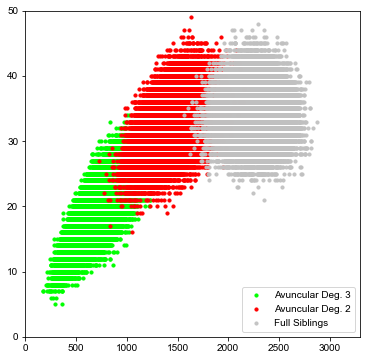

In [19]:
plt.figure(figsize=(6,6))
ax = plt.gca()
ax.scatter(dfa3["sum_IBD>12"], dfa3["n_IBD>12"], c="lime", s=10, label="Avuncular Deg. 3")
ax.scatter(dfa2["sum_IBD>12"], dfa2["n_IBD>12"], c="red", s=10, label="Avuncular Deg. 2")
#ax.scatter(dfc3["sum_IBD>12"], dfc3["n_IBD>12"], c="red", alpha=0.5, s=10)
ax.scatter(dffs["sum_IBD>12"], dffs["n_IBD>12"], c="silver", alpha=0.9, s=10, label="Full Siblings")

ax.set_xlim([0,3300])
ax.set_ylim([0,50])
ax.legend(loc="lower right")
plt.show()

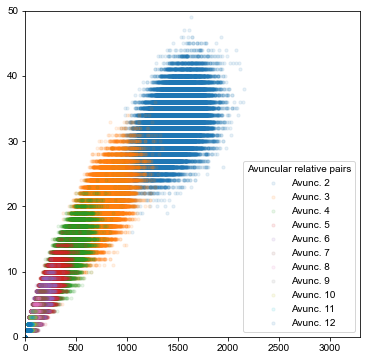

In [70]:
avs = [f"/mnt/archgen/users/hringbauer/output/pedsim/ben50kgap1/av{i}.tsv" for i in range(2,13)]
dfts = [pd.read_csv(p, sep="\t") for p in avs]

labels = [f"Avunc. {d}" for d in range(2,13)]




plt.figure(figsize=(6,6))
ax = plt.gca()

for dft,l in zip(dfts,labels):
    ax.scatter(dft["sum_IBD>12"], dft["n_IBD>12"], label=l, alpha=0.1, s=10)

ax.set_xlim([0,3300])
ax.set_ylim([0,50])
ax.legend(loc="lower right", title="Avuncular relative pairs")
plt.show()

# Plot all simulated relationships

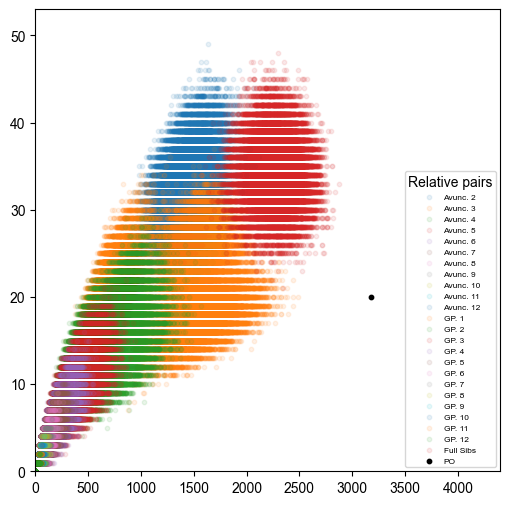

In [40]:
avs = [f"/mnt/archgen/users/hringbauer/output/pedsim/ben50kgap1/av{i}.tsv" for i in range(2,13)]
dfts = [pd.read_csv(p, sep="\t") for p in avs]
labels = [f"Avunc. {d}" for d in range(2,13)]

gps = [f"/mnt/archgen/users/hringbauer/output/pedsim/ben50kgap1/gp{i}.tsv" for i in range(1,13)]
dfts2 = [pd.read_csv(p, sep="\t") for p in gps]
labels2 = [f"GP. {d}" for d in range(1,13)]

dffs = pd.read_csv("/mnt/archgen/users/hringbauer/output/pedsim/ben50kgap1/fs.tsv", sep="\t") 
dfpo = pd.read_csv("/mnt/archgen/users/hringbauer/output/pedsim/ben50kgap1/po.tsv", sep="\t") 


plt.figure(figsize=(6,6))
ax = plt.gca()

for dft,l in zip(dfts,labels):
    ax.scatter(dft["sum_IBD>12"], dft["n_IBD>12"], label=l, alpha=0.1, s=10)

for dft,l in zip(dfts2,labels2):
    ax.scatter(dft["sum_IBD>12"], dft["n_IBD>12"], label=l, alpha=0.1, s=10)

ax.scatter(dffs["sum_IBD>12"], dffs["n_IBD>12"], label="Full Sibs", alpha=0.1, s=10)
ax.scatter(dfpo["sum_IBD>12"], dfpo["n_IBD>12"], label="PO", alpha=1, s=10, color="k")

ax.set_xlim([0,4400])
ax.set_ylim([0,53])
ax.legend(loc="lower right", title="Relative pairs", fontsize=6 )
plt.show()

# Plots of number of IBD segments

In [41]:
n3 = [np.mean(dft["n_IBD>12"]>2) for dft in dfts]
n2 = [np.mean(dft["n_IBD>12"]>1) for dft in dfts]
n1 = [np.mean(dft["n_IBD>12"]>0) for dft in dfts]

ne3 = [np.mean(dft["n_IBD>12"]==3) for dft in dfts]
ne2 = [np.mean(dft["n_IBD>12"]==2) for dft in dfts]
ne1 = [np.mean(dft["n_IBD>12"]==1) for dft in dfts]

Saved to /mnt/archgen/users/hringbauer/dumpster/ibd_fig.pdf


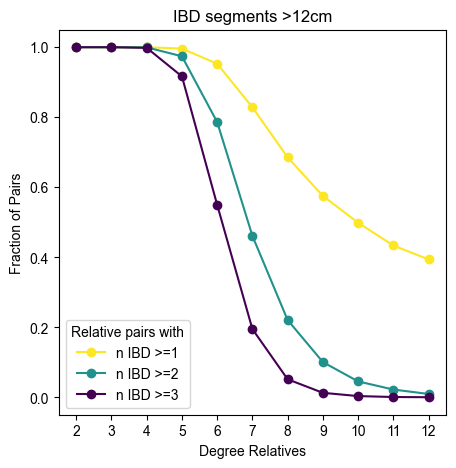

In [43]:
savepath="/mnt/archgen/users/hringbauer/dumpster/ibd_fig.pdf"

plt.figure(figsize=(5,5))
ax = plt.gca()

x = np.arange(2,13)
ax.plot(x, n1, "o-", label="n IBD >=1", c="#fde725")
ax.plot(x, n2, "o-", label="n IBD >=2", c="#21918c")
ax.plot(x, n3, "o-", label="n IBD >=3", c="#440154")

ax.legend(loc="lower left", title="Relative pairs with")
ax.set_xlabel("Degree Relatives")
ax.set_ylabel("Fraction of Pairs")

ax.set_title("IBD segments >12cm")

ax.set_xticks(np.arange(2,13))

if len(savepath)>0:
    plt.savefig(savepath, bbox_inches ='tight', pad_inches = 0, dpi=400)
    print(f"Saved to {savepath}")        
plt.show()

In [82]:
df12 = dfts2[-1]
np.mean(df12["n_IBD>12"]>1)

x = np.linspace(12,43,16)
x1 = x[:-1]+0.5

c = (df12["max_IBD"]>12)  & (df12["max_IBD"]<32) ### counts of value in that range
d = np.exp(-12*12/100) - np.exp(-32*12/100)

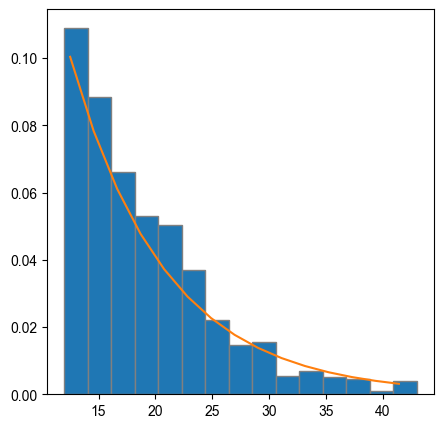

In [83]:
savepath=""

plt.figure(figsize=(5,5))
ax = plt.gca()

ax.hist(df12["max_IBD"], edgecolor="gray", bins=x, density=True)
ax.plot(x1, np.exp(-x1*12/100)*0.45)

if len(savepath)>0:
    plt.savefig(savepath, bbox_inches ='tight', pad_inches = 0, dpi=400)
    print(f"Saved to {savepath}")        
plt.show()

In [55]:
np.linspace(12,32,21)

array([12., 13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24.,
       25., 26., 27., 28., 29., 30., 31., 32.])

# IBD segments of different lengths

In [77]:
p20 = [np.mean(dft["n_IBD>20"]==1) for dft in dfts]
p16 = [np.mean(dft["n_IBD>16"]==1) for dft in dfts]
p12 = [np.mean(dft["n_IBD>12"]==1) for dft in dfts]

In [83]:
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}

Saved to /mnt/archgen/users/hringbauer/dumpster/ibd_fig_exact_n.pdf


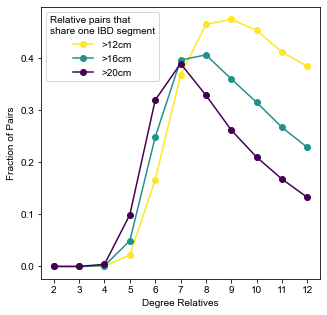

In [84]:
savepath="/mnt/archgen/users/hringbauer/dumpster/ibd_fig_exact_n.pdf"

plt.figure(figsize=(5,5))
ax = plt.gca()

x = np.arange(2,13)
ax.plot(x, p12, "o-", label=">12cm", c="#fde725")
ax.plot(x, p16, "o-", label=">16cm", c="#21918c")
ax.plot(x, p20, "o-", label=">20cm", c="#440154")

ax.legend(loc="upper left", title="Relative pairs that \nshare one IBD segment")
ax.set_xlabel("Degree Relatives")
ax.set_ylabel("Fraction of Pairs")

#ax.set_title("Exactly one IBD segment")

ax.set_xticks(np.arange(2,13))

if len(savepath)>0:
    plt.savefig(savepath, bbox_inches ='tight', pad_inches = 0, dpi=400)
    print(f"Saved to {savepath}")        
plt.show()

In [121]:
sem(dfc3["sum_IBD>8"])

1.3350032443055206

In [122]:
sem(dfa3["sum_IBD>8"])

1.4721623091339309

In [130]:
np.mean(dfa3["n_IBD>12"])

19.1755

In [131]:
np.mean(dfc3["n_IBD>12"])

20.339

In [129]:
sem(dfc3["n_IBD>20"])

0.03172650395340323

### Check PEDSIM map

In [39]:
dfm = pd.read_csv("/n/groups/reich/hringbauer/git/ped-sim/refined_mf.simmap", sep="\t")

In [44]:
dfm.groupby("#chr").apply

In [46]:
result = dfm.groupby("#chr").agg({'male_cM': ['min', 'max'], "female_cM":['min', 'max']})
df_a = result

In [ ]:
df_a

In [ ]:
(result["female_cM"]["max"] + result["male_cM"]["max"]) / 2

In [70]:
s = 0
for ch in range(1,23):
    with h5py.File(f"{h5_path}{ch}.h5", "r") as f: # Load for Sanity Check. See below!
                min_map, max_map =  f["variants/MAP"][0],f["variants/MAP"][-1]
    s+= max_map
    s-= min_map
    print(f"ch {ch}: {min_map:.5f} - {max_map:.5f}")

ch 1: 0.02013 - 2.86273
ch 2: 0.00014 - 2.68832
ch 3: 0.00004 - 2.23257
ch 4: 0.00341 - 2.14542
ch 5: 0.00040 - 2.04086
ch 6: 0.00318 - 1.92033
ch 7: 0.00004 - 1.87153
ch 8: 0.00000 - 1.68002
ch 9: 0.00164 - 1.66301
ch 10: 0.00006 - 1.80915
ch 11: 0.00000 - 1.58217
ch 12: 0.00090 - 1.74680
ch 13: 0.00190 - 1.25705
ch 14: 0.01607 - 1.20200
ch 15: 0.00005 - 1.41346
ch 16: -0.00000 - 1.34026
ch 17: -0.00026 - 1.28474
ch 18: 0.00160 - 1.17709
ch 19: 0.00002 - 1.07732
ch 20: 0.00001 - 1.08213
ch 21: 0.00861 - 0.62787
ch 22: 0.01723 - 0.74076
